# EDA for Parking tickets in Toronto Dataset

Here we are going to analyze the Parking Tickets in Toronto dataset for the year 2020. In this study, we will learn about the probability of getting a parking ticket in Toronto, as we will observe ticket occurrence trends with respect to date, time, address, vehicle plate province, and the fine amount. I hope by reading this notebook, the reader can save avoide occasions that have the highest probability rates to have a parking ticket in Toronto.

Let's begin with loading the necessary python packages for our code!

### 1. Load Data

In [2]:
# Import packages
import pandas as pd
import numpy as np
import os, glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update(plt.rcParamsDefault)
import calendar

Now let's define some functions to have a more organized and manageable code.

In [2]:
# define functions
def prob(x):
    x = round(x.div(len(data))*100, 2)
    return x

def get_prob_df(data, var_name1, var_name2, nlargest=None):
    y = data.groupby(var_name1)[var_name2].count().reset_index(name="count")
    y["probability"] = round(y["count"].div(len(data))*100, 2)
    y = y.sort_values('probability', ascending=False)
    if nlargest != None:
        y = y.nlargest(nlargest,'count')
    cum_prob = y["probability"].sum()
    print("Cumulative probability [%] = "+str(round(cum_prob, 1)))
    return y 

def plot_prob_bar_v(d, var_name, color='skyblue', line_at=None, title=None, var_label=None, tick_rot=None):
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(d[var_name], d["probability"], color=color, edgecolor='black', linewidth=0.7,width = 0.5)
    plt.ylabel("Probability of infractions [%]", fontsize=16)
    plt.xlabel(var_label, fontsize=16)
    plt.xticks(d[var_name],rotation=tick_rot)
    plt.title(title, fontsize=16)
    if line_at != None :
        plt.axhline(line_at, color='r', linestyle='dashed', linewidth=1)
        plt.legend([str(line_at)+'% probability'], loc='upper right')
    plt.show()
    return

def plot_prob_bar_h(d, var_name, color='skyblue', line_at=None, title=None, var_label=None, tick_rot=None):
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.barh(d[var_name], d["probability"], color=color, edgecolor='black', linewidth=0.7, height = 0.5)
    plt.xlabel("Probability of infractions [%]", fontsize=16)
    plt.ylabel(var_label, fontsize=16)
    plt.yticks(d[var_name],rotation=tick_rot)
    plt.title(title, fontsize=16)
    if line_at != None :
        plt.axvline(line_at, color='r', linestyle='dashed', linewidth=1)
        plt.legend([str(line_at)+'% probability'], loc='upper right')
    plt.show()
    return

def top(x, var_name, tn=3):
    if len(x) > tn:
        y = x[[var_name, "probability"]].sort_values('probability', ascending=False)
        y = y.reset_index(inplace=False, drop=True)
        y = y.iloc[0:tn]
    else:
        y = x[[var_name, "probability"]].sort_values('probability', ascending=False)
    return y

Now let's start our code and load our dataset!\
The 2020 dataset consists of 5 csv files, so we will need to loop over them.

In [9]:
# load data
path = "./data/"
# files = [file for file in glob.glob(path+"*.csv")]
files = [file for file in os.listdir("./data") if file.endswith('.csv')]
data = pd.DataFrame()
for file in files:
    data = pd.concat([data, pd.read_csv(path+file)], axis=0)

data.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,1.0,NaN,4700 JANE ST,NaN,NaN,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,OPP,573 CLENDENAN AVE,NaN,NaN,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,573 CLENDENAN AVE,NaN,NaN,ON
3,***46475,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,4.0,NR,21 MARIA ST,NaN,NaN,ON
4,***46674,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,4.0,NR,164 GLENHOLME AVE,NaN,NaN,ON


Our data is loaded successfully, in the next section we are going to dive more into our data to understand it before commencing our analysis.

### 2. Data Understanding

We can start by learnig about how data size.

In [9]:
data_len_0 = len(data)
data.shape

(1403663, 11)

We can find our data has 1.4M observations and 11 variables.\
Let's now learn about data variables data types.

In [5]:
data.dtypes

tag_number_masked          object
date_of_infraction          int64
infraction_code             int64
infraction_description     object
set_fine_amount             int64
time_of_infraction        float64
location1                  object
location2                  object
location3                  object
location4                  object
province                   object
dtype: object

We can find that the majority of our data variables have an object data type. As a result, we should expect our analysis to be primirlay baed on categorical analysis.\
In order to understand what every data variables reflect, let's pull up the variables description from the README file as follow,

#### Form README File:
* **tag_number_masked:** First three (3) characters masked with asterisks
* **date_of_infraction:** Date the infraction occurred in YYYYMMDD format
* **infraction_code:** Applicable Infraction code (numeric)
* **infraction_description:** Short description of the infraction
* **set_fine_amount:** Amount of set fine applicable (in dollars)
* **time_of_infraction:** Time the infraction occurred  in HHMM format (24-hr clock)
* **location1:** Code to denote proximity (see table below)
* **location2:** Street address
* **location3:** Code to denote proximity (optional)
* **location4:** Street address (optional)
* **province:** Province or state code of vehicle licence plate

From the README file we can observe the following,
* tag_number_masked data variable doesn't provide relevant useful information and consequently it can be discarded from the data analysis
* Similarly, infraction_code data variable can be discarded form data analysis as infraction_description data variables describe these codes and it can be used instead\

Now we can print the describe function for our data to learn more about the numerical features of the data.

In [6]:
data.describe().applymap('{:,.0f}'.format)

,date_of_infraction,infraction_code,set_fine_amount,time_of_infraction
count,"1,403,663","1,403,663","1,403,663","1,402,368"
mean,"20,200,678",77,50,"1,137"
std,384,121,48,602
min,"20,200,101",1,0,0
25%,"20,200,228",3,30,732
50%,"20,200,810",8,30,"1,200"
75%,"20,201,015",207,50,"1,604"
max,"20,201,231",435,450,"3,200"


From the describe table we can observe the following,
* Date of infraction data covers the whole 2020 year span form Jan. 1st 2020 to Dec. 31 2020.
* The tickets fine amounts in dollars range between 0 to 450$ where 50% of fines are of 30$ or less and 75% of fines are of 50$ or less.
* Also, having fines of amount 0$ should represent a noise in the data.
* The time of infraction has a maximum if 32:00 HR:MIN, whcih is not logical and times > 24:00 will need to be discared for the analysis.\

Now we can proceed with further exploration and let's learn about the number of unique values/categories we have in our dataset.

In [7]:
print("Number of unique values stat:")
data.nunique()

Number of unique values stat:


tag_number_masked         100000
date_of_infraction           366
infraction_code              156
infraction_description       168
set_fine_amount               14
time_of_infraction          1446
location1                    356
location2                 166530
location3                     58
location4                   3009
province                      66
dtype: int64

From the unique values stat we can learn that our dataset has a high number of categories which leads to a more challenging categorical analysis. But let's have more fun!\

Now let's discover the amount of null/na values we have in our data.

In [8]:
x = prob(data.isnull().sum())
print("Percentage of null values in data: ")
x

Percentage of null values in data: 


tag_number_masked          0.00
date_of_infraction         0.00
infraction_code            0.00
infraction_description     0.00
set_fine_amount            0.00
time_of_infraction         0.09
location1                 12.59
location2                  0.01
location3                 92.92
location4                 92.89
province                   0.00
dtype: float64

Based on th enull values stat we can observe the following,
* location3 and location4 have the highest percentage of null data and it's almost 93%.
* location1 has comes third in terms of null data in terms of percentage that's around 12.5%
* The rest of the data variables have zero or near zero null data (Good!)
* As a result, we can conclude that investig location will be mainly based on location1 and location2. 

But before moving forward, let's have a deeper understanding of location1 and location2 variables by investigating their unique values.  

In [9]:
# Proxomity
data["location1"].unique()

array([nan, 'OPP', 'NR', 'W/S', 'AT', 'E/S', 'N/S', 'S/S', 'R/O',
       'NEARE/B', 'W/O', 'S/O', 'N/O', '25', 'NEAR', 'N/R', 'NEAW/B',
       'NEARW/B', 'NEAR E/B', 'E/O', 'TOR PKG', 'AR', 'ATR', '415',
       'NEAR EB', 'ATE/B', 'N/B', 'N/W CORNER', 'NEAR N/B', 'NEAR WB',
       'REAR OF', 'MEAR', '2020', '75', '200 ', 'AT 19 ', 'NR E/B',
       'NR EB', '315', '567', '8', 'QT', 'AT ', '1750', '145', 'ON',
       'NEAR W/B', '775', '4001', '79', 'NEAR S/B', 'NEARN/B', '705',
       'V/P', 'BEARE/B', 'NEA E/B', 'NRS/S OF', '3735', '2', '373', 'WS',
       'REAR', 'NR/N', 'NR N/E', '126', 'ST', '1571', '296', '18', 'MR',
       '2413', '7 ', 'REAR/OF', '11', '5667', '10', '17', '101',
       'NR W OF', '1030', '2760 ', 'EB', 'E/B', '4256', 'W/B', '200',
       '167', '7', '2075', 'AT EB', '4700', '701', '285', '1750 ', 'O/F',
       '12', 'OPPOSITE', '5', '6040', '51 ', 'N', '50', 'NO', '20', '80',
       'AY', 'AZ35349', '45', '3', '107', '2170', 'X', '80 ', '4001 ',
       '675', '12

By looking at location1 data points we can observe the following:
* There is no consistant use of proxomity codes and the other data oints are not descriptive enough (i.e., building number). There is a lot of noise as a result.
* we can conclude that location1 variable might be discared as well for the analysis.\

Similarly, let's look at location2 iunique values.

In [10]:
# Street names
data["location2"].unique()

array(['4700 JANE ST', '573 CLENDENAN AVE', '21 MARIA ST', ...,
       '70 BAY ST', '8 GOD STONE RD', '245 WAVERLEY RD'], dtype=object)

While location2 variable has a tramendous number of unique values, we can observe the following,
* By some text processing we can seperate street names and have more useful form of data with less noise.\

Now let's move on to our last categorical variables: vehicle plate province.\
Here we look at the distribution by percentage for the top 15 province.

In [11]:
x = pd.crosstab(index=data['province'], columns='count').nlargest(15,'count')
x = prob(x)
print("Percentage ditribution of vehicles plates' provinces:")
x

Percentage ditribution of vehicles plates' provinces:


col_0,count
province,
ON,96.72
QC,1.43
AB,0.31
AZ,0.21
NS,0.15
BC,0.13
PQ,0.13
MB,0.12
NY,0.12


We can observe the following,  
* The province variable data is heavily unbalanced as > 95% of it are ON plates.
* As a result, we can investigate ON vs. outside-ON for more practical and meaningful analysis.

### 3. Feature Selection, Data Cleaning, and Processing

#### 3.1 Feature Selection

Based on understanding on the data in the previous section, we going te select most relevant and meangful features that can help us in our data analysis.\
As aresult we going to drop the following variables,
* tag_number_masked
* infraction_code
* location1
* location3
* location4

In [12]:
# get columns indices
data.columns

Index(['tag_number_masked', 'date_of_infraction', 'infraction_code',
       'infraction_description', 'set_fine_amount', 'time_of_infraction',
       'location1', 'location2', 'location3', 'location4', 'province'],
      dtype='object')

In [13]:
# Feature Selction
data = data.drop(data.columns[[0, 2, 6, 8, 9]], axis=1)
data.head()

,date_of_infraction,infraction_description,set_fine_amount,time_of_infraction,location2,province
0,20200101,PARK ON PRIVATE PROPERTY,30,1.0,4700 JANE ST,SK
1,20200101,PARK PROHIBITED TIME NO PERMIT,30,2.0,573 CLENDENAN AVE,ON
2,20200101,PARK PROHIBITED TIME NO PERMIT,30,2.0,573 CLENDENAN AVE,ON
3,20200101,PARK PROHIBITED TIME NO PERMIT,30,4.0,21 MARIA ST,ON
4,20200101,PARK PROHIBITED TIME NO PERMIT,30,4.0,164 GLENHOLME AVE,ON


Here after reducing our data to only with the variables selected for our analysis.\

Now let's rename our data variables names to easy to remember and code names for a faster and more effective coding.

In [14]:
data.rename(columns = {'date_of_infraction':'DATE', 'infraction_description':'DESC', 'set_fine_amount':'FA', 'time_of_infraction':'TIME',
'location2':'ADDRESS', 'province':'PROV' }, inplace = True)
data.head()

,DATE,DESC,FA,TIME,ADDRESS,PROV
0,20200101,PARK ON PRIVATE PROPERTY,30,1.0,4700 JANE ST,SK
1,20200101,PARK PROHIBITED TIME NO PERMIT,30,2.0,573 CLENDENAN AVE,ON
2,20200101,PARK PROHIBITED TIME NO PERMIT,30,2.0,573 CLENDENAN AVE,ON
3,20200101,PARK PROHIBITED TIME NO PERMIT,30,4.0,21 MARIA ST,ON
4,20200101,PARK PROHIBITED TIME NO PERMIT,30,4.0,164 GLENHOLME AVE,ON


#### 3.2 Data Cleaning

Now let's clean our data from nul/na and/or illogical data points as per our investigation in section 1.

First, let's have a nother look at the null/na vaules of the selected variables.

In [15]:
x = prob(data.isnull().sum())
print("Percentage of null values in data: ")
x

Percentage of null values in data: 


DATE       0.00
DESC       0.00
FA         0.00
TIME       0.09
ADDRESS    0.01
PROV       0.00
dtype: float64

We can find that nul/na data points are ~ 0.1% at its maximum for the TIME variable. Therefoer, we can drop this data points without having an impact on the accuracy of our data analysis. 

Similarly, we will clean the dataset from iilogical data points, such as TIME > 24:00.

Lastly, having fractions of fine amounts near or equal to zero should reflect noise/false data input. As a result, these data ponts will be droped as well.

In [16]:
# drop na data and zeros
data = data[data.loc[:]!=0].dropna()

# dorp time > 24:00
data = data[(data.TIME <= 2400)]

# drop whre FA = 0
data = data[(data.FA > 1)]

Now let's check if the data cleaning was done successfully.

In [17]:
# Check nul/na values
x = prob(data.isnull().sum())
print("Percentage of null values in data: ")
display(x)

Percentage of null values in data: 


DATE       0.0
DESC       0.0
FA         0.0
TIME       0.0
ADDRESS    0.0
PROV       0.0
dtype: float64

In [18]:
# check numerical variables: TIME and FA
data.describe().applymap('{:,.0f}'.format)

,DATE,FA,TIME
count,"1,401,840","1,401,840","1,401,840"
mean,"20,200,679",50,"1,137"
std,384,48,602
min,"20,200,101",15,1
25%,"20,200,228",30,732
50%,"20,200,810",30,"1,200"
75%,"20,201,015",50,"1,604"
max,"20,201,231",450,"2,359"


We can find that now we have no nul/na data points nor FA = 0 nor TIME > 24:00. Mission accomplished!\

However, before moving to the next step to do some data processing. It's important to check the amount of data we have dropped relative to the original data size. That's to make sure we have not done any excessive data cleaning.

In [19]:
# check precentage of dropped data
d = (data_len_0-len(data))*100/data_len_0
print("Precentage of Discarded Data= "+str(round(d ,2))+" %")

Precentage of Discarded Data= 0.13 %


That's great we had to only drop 0.13% of our data which is an insignificant amount that won't affect our data analysis accuracy.

Now let's move to the last step before starting our data analysis which is doing some data processing that will help us in our analysis.

#### 3.3 Data Processing

Here we are going to process some of the data variables so that we turn them into a form that is easier and more useful for us to use in our data analysis.
For example, we are going to do the following,
* Change TIME variable data points from HR:MIN real numbers distribution format to a discrete distribution that only consists of 24 values of hrs from 0 to 23.
* Combine all non-ON data points for the PROV variable to only one category called "outside-ON", since all non-ON data points account for less than 3.5% of all data points.
* Convert the MONTH variable data points format from real number distribution to categories of the 12 months of the year (Jan. to Dec.)
* Extract street names from ADDRESS variable and discard the other unnecessary information (i.e., bldg/block number).

In [20]:
# Convert Time data to intervals
data["TIME"] = data["TIME"]/100
data["TIME"] = data["TIME"].astype(int)

# Group Province.
data["PROVG"] = data["PROV"].where(data["PROV"] == 'ON', 'outside-ON')

# Add Months column
data['MONTH_NUM'] = pd.to_datetime(data['DATE'],format='%Y%m%d').dt.month
data['MONTH'] = data['MONTH_NUM'].apply(lambda x: calendar.month_abbr[x])

# Extract Street names
data["ST"] = data["ADDRESS"].str.replace('\d+', '')

After proccessing our data variables and appending our data with the newly introduced forms of variables, let's drop the original variables. While this step is not necessary but it's better to minimize the amount of unnecessary amount of data and memory as much as possible.

In [21]:
# Drop unneeded variables
data = data.drop(['DATE', 'ADDRESS', 'PROV', 'MONTH_NUM'], axis = 1)

# Have a final look at our data!
data.head()

,DESC,FA,TIME,PROVG,MONTH,ST
0,PARK ON PRIVATE PROPERTY,30.0,0,outside-ON,Jan,JANE ST
1,PARK PROHIBITED TIME NO PERMIT,30.0,0,ON,Jan,CLENDENAN AVE
2,PARK PROHIBITED TIME NO PERMIT,30.0,0,ON,Jan,CLENDENAN AVE
3,PARK PROHIBITED TIME NO PERMIT,30.0,0,ON,Jan,MARIA ST
4,PARK PROHIBITED TIME NO PERMIT,30.0,0,ON,Jan,GLENHOLME AVE


Finally, data processing has been completed successfully!

### 4. Data Analysis and Trends Investigation

Now, it's time to analyze our data! Since the purpose of this EDA is to learn about the probability of getting a parking ticket in Toronto, our analysis will be focused on calculating, analyzing, and observing trends of the infraction occurrence rate/probabilities. 

First, let's analyze the probability of a vehicle being from Ontario or outside of it given the car did a parking infraction.

Cumulative probability [%] = 100.0


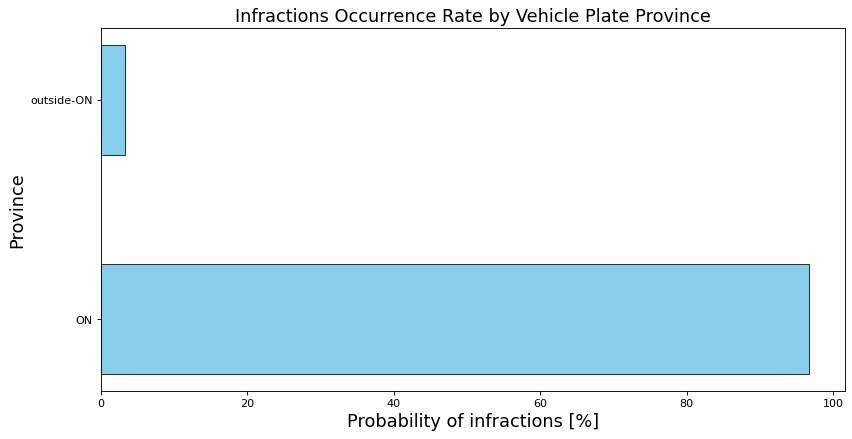

,PROVG,count,probability
0,ON,1355929,96.72
1,outside-ON,45911,3.28


In [22]:
# Province Probability Summary
PROVG = get_prob_df(data, "PROVG", "PROVG")
plot_prob_bar_h(PROVG, "PROVG", color='skyblue', line_at=None, title="Infractions Occurrence Rate by Vehicle Plate Province", var_label="Province", tick_rot=None)
PROVG

We can find that there is nearly 97% probability for a vehicle to be from Ontario given it had a parking ticket in Ontario. It is worth mentioning that this probability is very high due to the fact that Toronto is in Ontario, and that the majority of cars in Toronto will have Ontario plates in the first place. However, we can expect from these results that there is no inherit bias to ticket cars from outside of Ontario.

Second, we are going to analyze the probabilities of getting a certain fine amount in terms of dollars in Toronto given the car did a parking infraction.

Cumulative probability [%] = 100.0


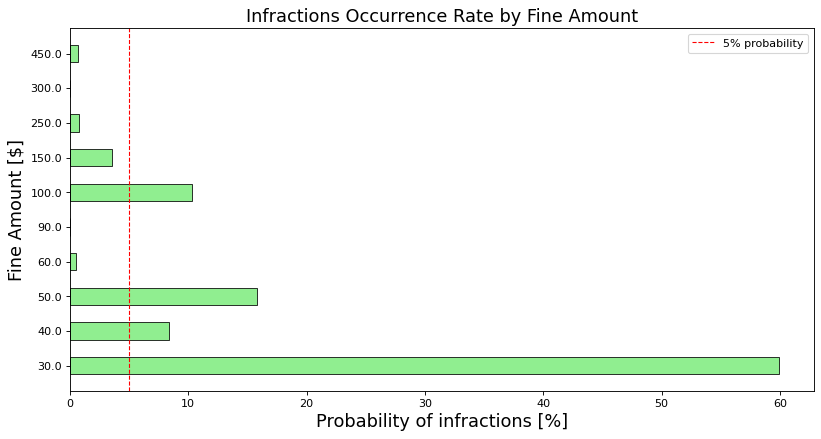

,FA,count,probability
1,30.0,839536,59.89
2,40.0,117308,8.37
3,50.0,222055,15.84
5,60.0,7299,0.52
6,90.0,514,0.04
7,100.0,144972,10.34
8,150.0,49681,3.54
10,250.0,10476,0.75
11,300.0,132,0.01
12,450.0,9797,0.70


In [23]:
# Fine Amount Probability Summary
FA = get_prob_df(data, "FA", "FA", nlargest=10)
FA = FA.sort_values("FA", ascending=True)
FA["FA"] = FA["FA"].astype(str)
plot_prob_bar_h(FA, "FA", color='lightgreen', line_at=5, title="Infractions Occurrence Rate by Fine Amount", var_label="Fine Amount [$]", tick_rot=None)
FA

We can observe from the fine amount probabilities chart the following, 
* The vast majority of parking infractions have a ticket value of 30$, with 60% probability.
* Ticket values of 50$ and 40$ come in the second and third places with probabilities near 16%, and 8% respectively.
* Luckily, the probability of having a fine amount greater than 100$ when doing a parking infraction is only 5%. 

Third, let's discover what parking infractions categories are mostly fined! 

Cumulative probability [%] = 91.9


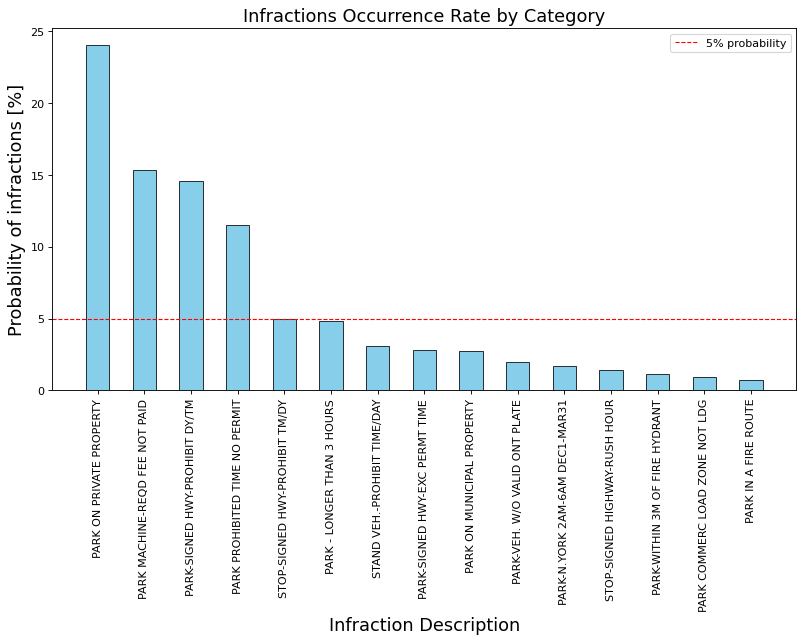

,DESC,count,probability
44,PARK ON PRIVATE PROPERTY,336994,24.04
35,PARK MACHINE-REQD FEE NOT PAID,215035,15.34
85,PARK-SIGNED HWY-PROHIBIT DY/TM,204577,14.59
52,PARK PROHIBITED TIME NO PERMIT,161695,11.53
137,STOP-SIGNED HWY-PROHIBIT TM/DY,69246,4.94
10,PARK - LONGER THAN 3 HOURS,67391,4.81
104,STAND VEH.-PROHIBIT TIME/DAY,43241,3.08
83,PARK-SIGNED HWY-EXC PERMT TIME,39759,2.84
43,PARK ON MUNICIPAL PROPERTY,38665,2.76
88,PARK-VEH. W/O VALID ONT PLATE,27656,1.97


In [24]:
# Province Probability Summary
DESC = get_prob_df(data, "DESC", "DESC", nlargest=15)
plot_prob_bar_v(DESC, "DESC", color='skyblue', line_at=5, title="Infractions Occurrence Rate by Category", var_label="Infraction Description", tick_rot=90)
DESC

Among over 100 parking infractions, only the following 5 categories have over 70% of parking infractions tickets as per their calculated probabilities,
* Park on private property
* Park machine-req fee not paid
* Park-signed hwy-prohibit daytime
* Park porhibited time no permit
* Stop-signed hwy-prohibit daytime

By only avoiding these 5 parking infractions categories we tremendously reduce the likelihood of having a parking infraction ticket in Toronto.\
Moreover, by avoiding the top 15 parking infractions categories displayed in chart above, we eliminate over 90% of the likelihood of having a parking infraction ticket in Toronto.


Forth, it's time to know what times of the year have higher probabilities of parking infractions in Toronto.

Cumulative probability [%] = 100.0


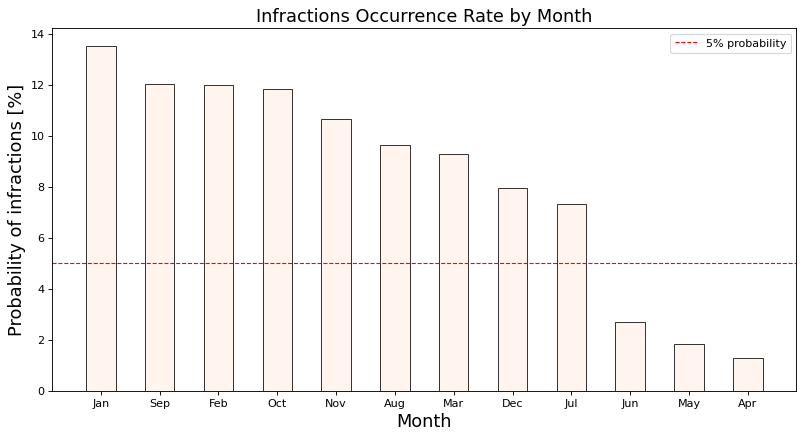

,MONTH,count,probability
4,Jan,189729,13.53
11,Sep,168649,12.03
3,Feb,167823,11.97
10,Oct,165851,11.83
9,Nov,149141,10.64
1,Aug,135132,9.64
7,Mar,130186,9.29
2,Dec,111616,7.96
5,Jul,102559,7.32
6,Jun,37785,2.70


In [25]:
# Month Probability Summary
MONTH = get_prob_df(data, "MONTH", "MONTH", nlargest=13)
plot_prob_bar_v(MONTH, "MONTH", color='seashell', line_at=5, title="Infractions Occurrence Rate by Month", var_label="Month", tick_rot=None)
MONTH

We can observe from the above chart the follwoing probobailities distrubtion for the years' months,
* Jan. to Mar. ~ 10 to 14%
* Jul. to Dec. ~ 7 to 12%
* Apr. to Jun. ~ 1 to 3%

So it's obvious that the parking infractions are not evenly distributed over the year, where winter months Jan. to Mar. have the highest probability distribution while spring months Apr. to Jun. have the least probability distribution. Do want to have fun in Toronto with car parking stress free? Spring is the time!

Fifth, let's discover which placeses in Toronto are to avoid to park in!

Cumulative probability [%] = 15.5


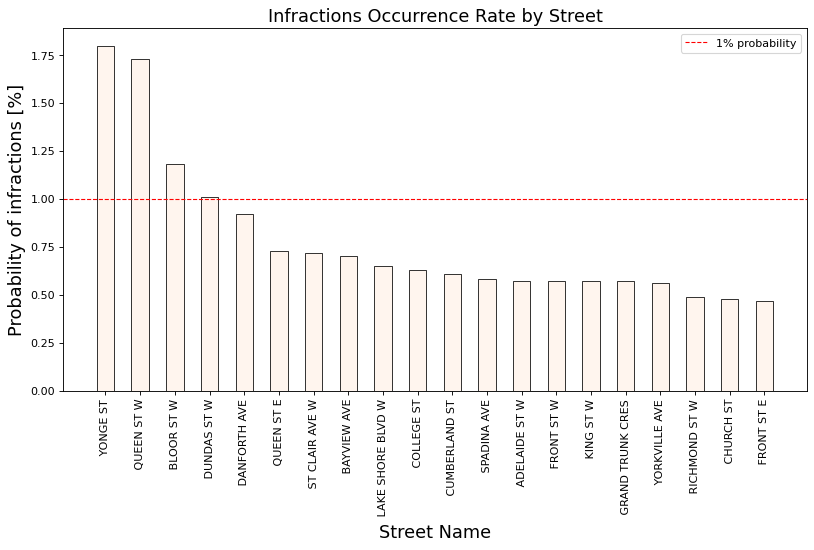

,ST,count,probability
13457,YONGE ST,25229,1.80
9985,QUEEN ST W,24190,1.73
2009,BLOOR ST W,16592,1.18
4094,DUNDAS ST W,14163,1.01
3604,DANFORTH AVE,12965,0.92
9983,QUEEN ST E,10296,0.73
11511,ST CLAIR AVE W,10079,0.72
1612,BAYVIEW AVE,9835,0.70
7270,LAKE SHORE BLVD W,9170,0.65
3203,COLLEGE ST,8866,0.63


In [26]:
# Month Probability Summary
ST = get_prob_df(data, "ST", "ST", nlargest=20)
plot_prob_bar_v(ST, "ST", color='seashell', line_at=1, title="Infractions Occurrence Rate by Street", var_label="Street Name", tick_rot=90)
ST

As we can observe that, among thousands of streets in Toronto, the following are the top 5 streets that you need to avoid parking in while being in Toronto,
* Young ST, probability = 1.8 %
* QUEEN ST W, probability = 1.73 %
* BLOOR ST W, probability = 1.18 %
* DUNDAS ST W, probability = 1.01 %
* DANFOTH AVE, probability = 0.92 %

But what places should we look for to park our cars without stressting about having a ticket?

Let's get a list of the top 100 streets in Toronto to look for to park your car, where it's rare to have a parking ticket in those streets - the probability is almost zero!

In [27]:
ST_low_prob = data.groupby("ST")["ST"].count().reset_index(name="count").nsmallest(100,'count').sort_values('count', ascending=True)
ST_low_prob['probability'] = ST_low_prob['count']*100/len(data)
ST_low_prob

,ST,count,probability
1,,1,0.000071
137,KENSINGTON AVE,1,0.000071
136,KENASTON GDNS,1,0.000071
135,KEITH AVE,1,0.000071
133,JOSEPH DUGGAN RD,1,0.000071
...,...,...,...
51,COSBURN AVE,1,0.000071
49,COLONEL SAMUEL DR,1,0.000071
47,COLERIDGE AVE,1,0.000071
69,DUNKIRK RD,1,0.000071


Here you go, now you have the list of the top 100 streets in Toronto to look for to park your car in stress-free.

Lastly, let's uncover trends between parking infractions tickes and the time of the day.

Cumulative probability [%] = 100.0


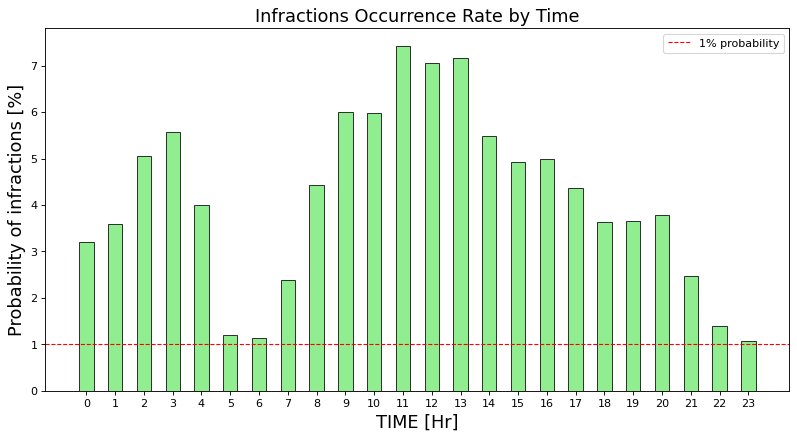

,TIME,count,probability
11,11,104113,7.43
13,13,100410,7.16
12,12,98928,7.06
9,9,84271,6.01
10,10,83678,5.97
3,3,78209,5.58
14,14,77004,5.49
2,2,70839,5.05
16,16,69963,4.99
15,15,69004,4.92


In [28]:
# Time of infraction probability
TIME = get_prob_df(data, "TIME", "TIME", nlargest=None)
plot_prob_bar_v(TIME, "TIME", color='lightgreen', line_at=1, title="Infractions Occurrence Rate by Time", var_label="TIME [Hr]", tick_rot=None)
TIME

We can observe the following from the parking infractions tickets distribution above,  
* Parking infractions tickets distribution across the daytime has a bimodal distribution, where it peaks between 11:00 AM to 2:00 PM and 2:00 AM to 4:00 AM, by having probabilities that range from ~ 5.5% to 7.5% and ~ 4% to 5.5%, respectively per each hour.
* The majority of the parking infractions tickets take place during day-time hours 8:00 AM to 8:00 PM, by having probabilities that range from ~ 4% to 7.5% per each hour.
* The least hours where parking tickets occur are 5:00 AM to 7:00 AM and 10:00 PM to 00:00 AM, by having probabilities that range from ~ 1.1% to 1.2% and ~ 1.1% to 1.4%, respectively per each hour

## 5. EDA Summary

Here we present a summary of EDA performed for the Toronto parking tickets dataset for the year 2020. We analyzed the data with the purpose of learning about the probability of getting a parking ticket in Toronto. As a result, data has been explored and investigated to uncover trends across all dataset features. The uncovered probability trends are summarized for each data feature as follows,

* **Vehicle Province:**
    * We can find that there is nearly 97% probability for a vehicle to be from Ontario given it had a parking ticket in Ontario. 
    * It is worth mentioning that this probability is very high due to the fact that Toronto is in Ontario, and that the majority of cars in Toronto will have Ontario plates in the first place. 
    * However, we can expect from these results that there is no inherent bias to ticket cars from outside of Ontario.

* **Fine Amount:**
    * The vast majority of parking infractions have a ticket value of 30$, with a 60% probability.
    * Ticket values of 50$ and 40$ come in the second and third places with probabilities near 16%, and 8% respectively.
    * Luckily, the probability of having a fine amount greater than 100$ when doing a parking infraction is only 5%.


* **Infraction Category:**\
Among over 100 parking infractions, only the following 5 categories have over 70% of parking infractions tickets as per their calculated probabilities,
    * Park on private property
    * Park machine-req fee not paid
    * Park-signed hwy-prohibit daytime
    * Park prohibited time no permit
    * Stop-signed hwy-prohibit daytime

    By only avoiding these 5 parking infractions categories we tremendously reduce the likelihood of having a parking infraction ticket in Toronto.\
    Moreover, by avoiding the top 15 parking infractions categories, we eliminate over 90% of the likelihood of having a parking infraction ticket in Toronto.

* **Address:**\
Among thousands of streets in Toronto, the following are the top 5 streets that you need to avoid parking in while being in Toronto,
    * Young ST, probability = 1.8 %
    * QUEEN ST W, probability = 1.73 %
    * BLOOR ST W, probability = 1.18 %
    * DUNDAS ST W, probability = 1.01 %
    *  DANFOTH AVE, probability = 0.92 %


* **Year Time (Month):**\
The parking infractions are not evenly distributed over the year, where winter months Jan. to Mar. have the highest probability distribution while spring months Apr. to Jun. have the least probability distribution. The probability distribution is as follows,
    * Jan. to Mar. ~ 10 to 14%
    * Jul. to Dec. ~ 7 to 12%
    * Apr. to Jun. ~ 1 to 3%


* **Day Time:**\
Parking infractions ticktes distribution accros the day time has a bimodal distribution.
    * Parking ticket's likelihood peaks between 11:00 AM to 2:00 PM and 2:00 AM to 4:00 AM, by having probabilities that range from ~ 5.5% to 7.5% and ~ 4% to 5.5%, respectively per hour.
    * The majority of the parking infractions tickets take place during day-time hours 8:00 AM to 8:00 PM, by having probabilities that range from ~ 4% to 7.5% per each hour.
    * The least hours where parking tickets occur are 5:00 AM to 7:00 AM and 10:00 PM to 00:00 AM, by having probabilities that range from ~ 1.1% to 1.2% and ~ 1.1% to 1.4%, respectively per each hour.